# Initialization

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline, make_union, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
import my_utils


In [2]:
train=pd.read_csv('../data/data.csv.zip', compression='zip', index_col=1)
train=train.drop(columns=['Unnamed: 0'])

# Data cleaning

In [3]:
train.columns = my_utils.clean_column_names(train)
train = my_utils.preprocess_columns(train)
train.columns

Index(['name', 'age', 'nationality', 'overall', 'potential', 'club', 'value',
       'wage', 'special', 'preferred_foot', 'international_reputation',
       'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face',
       'position', 'jersey_number', 'joined', 'loaned_from',
       'contract_valid_until', 'height', 'weight', 'ls', 'st', 'rs', 'lw',
       'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm',
       'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb',
       'crossing', 'finishing', 'headingaccuracy', 'shortpassing', 'volleys',
       'dribbling', 'curve', 'fkaccuracy', 'longpassing', 'ballcontrol',
       'acceleration', 'sprintspeed', 'agility', 'reactions', 'balance',
       'shotpower', 'jumping', 'stamina', 'strength', 'longshots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standingtackle', 'slidingtackle', 'gkdiving',
       'gkhandling', 'gkkicking', 'gk

# Features selection

In [4]:
train.shape

(18207, 88)

In [5]:
features = ['age', 'potential', 'international_reputation',
            'weak_foot', 'skill_moves', 'crossing', 'finishing', 'headingaccuracy', 
            'shortpassing', 'volleys', 'dribbling', 'curve', 'fkaccuracy', 'longpassing',
            'ballcontrol', 'acceleration', 'sprintspeed',
            'agility', 'reactions', 'balance', 'shotpower', 'jumping', 'stamina', 
            'strength', 'longshots', 'aggression', 'interceptions', 'positioning', 'vision', 
            'penalties', 'composure', 'marking', 'standingtackle', 'slidingtackle', 'gkdiving', 
            'gkhandling', 'gkkicking', 'gkpositioning', 'gkreflexes']

target = ['overall']


# Define model

In [6]:
mlp = MLPRegressor(hidden_layer_sizes=(128,128), max_iter=300, alpha=1e-4,
                    solver='adam', verbose=False, tol=1e-4, random_state=1,
                    learning_rate_init=.001)


In [7]:
X = train[features].values
y = train.overall.values


Hold back 10% of the data for test.  There are 18K records in all, so we hold back 1.8K records.
We use KFold validation with number of folds = 3 that gives 5K records in the validation set in each iteration.

Stratified KFold expects distinct classes in the target, but here the target is numerical (overall), therefore I am using KFold.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=41)


Imputation with missing indicator gives a slightly better score on the test compared to just the imputation without missing indicator.
Acknowledgements - https://scikit-learn.org/stable/modules/impute.html#impute

Create pipeline to transform the data, scale it and use MLP regressor.


In [9]:
results = []
val_results = []
#print("Processing model: ", mlp)
transformer = FeatureUnion(
transformer_list=[
    ('features', SimpleImputer(strategy='mean'))
    ,('indicators', MissingIndicator())
])
transformer = transformer.fit(X_train, y_train)
results = transformer.transform(X_test)
results.shape
reg = make_pipeline(transformer, StandardScaler(), mlp)
# print("Regressor is: ", mlp)
                       
kfold = KFold(n_splits=3, shuffle=True)

cv_scores = []
for t, val in kfold.split(X_train, y_train):
    reg.fit(X_train[t], y_train[t])
    #print("Model fit...")
    cv_score = reg.score(X_train[val], y_train[val])
    print("Validation score for regressor... %.4f" % cv_score)
    cv_scores.append(cv_score)
    #print("loss", mlp.loss_)
    #print("coefs", mlp.coefs_)
    #print("intercepts", mlp.intercepts_)
    #print("n_iter", mlp.n_iter_)
    #print("n_layers", mlp.n_layers_)
    #print("n_outputs", mlp.n_outputs_)
    #print("out_activation", mlp.out_activation_)


#val_results.append((model, cv_scores))



Validation score for regressor... 0.9916
Validation score for regressor... 0.9913
Validation score for regressor... 0.9920


# Evaluate accuracy

In [10]:
print("Generating test scores for regressor... ")

score = reg.score(X_test, y_test)
print("Test score for regressor... %.4f" % score)
#results.append((model, score))


Generating test scores for regressor... 
Test score for regressor... 0.9922


# Make predictions

In [11]:
predictions = reg.predict(X_test)
predictions[0]

74.81213512401442

In [12]:
y_test[0]

73

Text(0.5, 1.0, 'Plot first 50 test overall score and their predictions.')

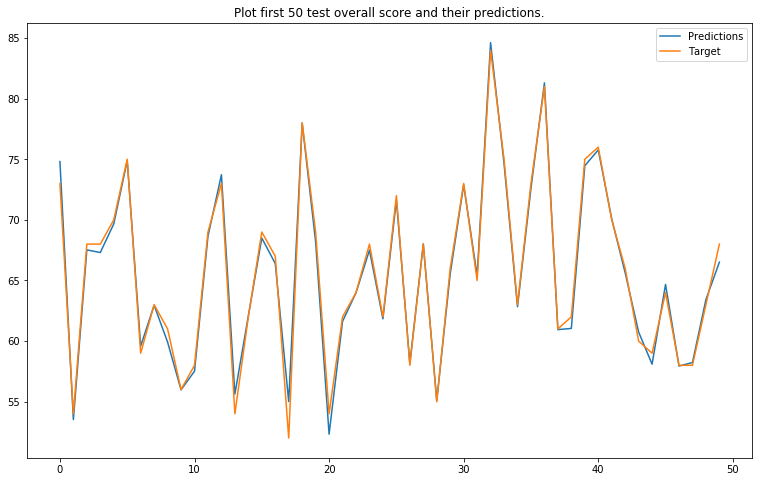

In [13]:
num=50
plt.figure(figsize=(13,8))
plt.plot(predictions[:num])
plt.plot(y_test[:num])
plt.legend(("Predictions", "Target"))
plt.title("Plot first {0} test overall score and their predictions.".format(num))